In [1]:
%run preamble.ipynb


## The preamble handles a few imports.
## It also loads common functions and dicts: 

## Bosch challenge specific:
* **getMCC**(tp,tn,fp,fn)

## ML/Analytics functions:
* **compare_train_test**(clf, ds_train, label_train, ds_test, label_test, mva='MVA', bins=50, use_vote=None, log=False)
* **plot_classifier_output**( pred_train, pred_test, y_train, y_test, multipagepdf=None, bins = None, normalised = True )
* **plot_correlations**(data,label='', \*\*kwds)
* **optimisePars**(mva, points, data , classes, fraction=0.7, score = 'log_loss', cvs=5)

---

## Various
* **showUniques**(df)
* **ensure_dir**(directory)
* **printBumper**(text, c='=', n=-1)
* **intersec**(d1, d2)
* **union**(d1, d2)

---

## Color dictionaries:
* **Tableau10**
* **Tableau10_Light**
* **Tableau10_Medium**
* **Tableau_20**
* **ColorBlind10**


In [2]:
%ls files

 Volume in drive C has no label.
 Volume Serial Number is 9C71-F73D

 Directory of C:\Users\maxxo_000\cygwin\Kaggle\Bosch\files

03.09.2016  13:29    <DIR>          .
03.09.2016  13:29    <DIR>          ..
03.09.2016  00:11            53.790 lsf_mean_std.csv
03.09.2016  13:25     2.678.272.381 test_categorical.csv
03.09.2016  13:27     2.893.227.216 test_date.csv
02.09.2016  22:47     2.137.286.201 test_numeric.csv
03.09.2016  12:37        70.051.382 trai_statspvals.csv
03.09.2016  13:26     2.678.343.036 train_categorical.csv
03.09.2016  13:30     2.893.367.134 train_date.csv
03.09.2016  12:29            10.141 train_nan_pvals.csv
02.09.2016  22:48     2.139.901.506 train_numeric.csv
               9 File(s) 15.490.512.787 bytes
               2 Dir(s)  26.105.147.392 bytes free


In [2]:
cols = ["L0_S0_F0","L0_S12_F348", "L0_S23_F671","L1_S24_F882",
"L1_S24_F1463","L1_S25_F3028", "L2_S27_F3218","L2_S28_F3303",
"L3_S29_F3382", "L3_S30_F3729", "L3_S49_F4216","Response"]

In [3]:
train_num = pd.read_csv("files/train_numeric.csv", 
                        usecols=cols)

In [4]:
train_num.head(5)

,L0_S0_F0,L0_S12_F348,L0_S23_F671,L1_S24_F882,L1_S24_F1463,L1_S25_F3028,L2_S27_F3218,L2_S28_F3303,L3_S29_F3382,L3_S30_F3729,L3_S49_F4216,Response
0,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054,0.0,NaN,0
1,NaN,-0.029,NaN,NaN,NaN,NaN,NaN,NaN,-0.050,0.0,NaN,0
2,0.088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047,0.0,NaN,0
3,-0.036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024,0.0,NaN,0
4,-0.055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.128,0.0,NaN,0


In [5]:
gb = train_num.groupby("Response")

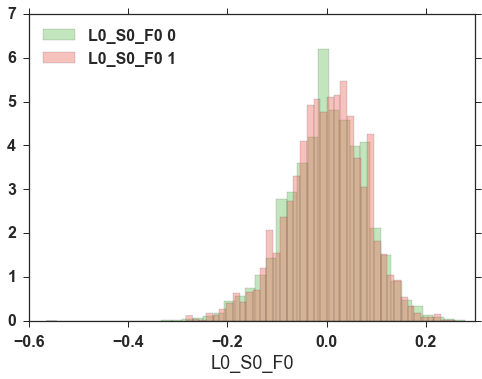

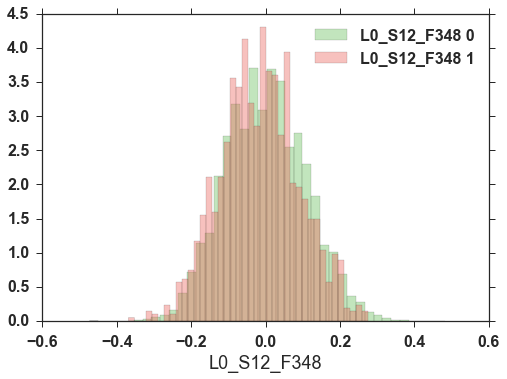

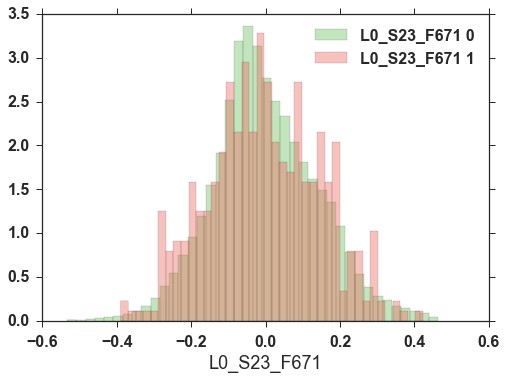

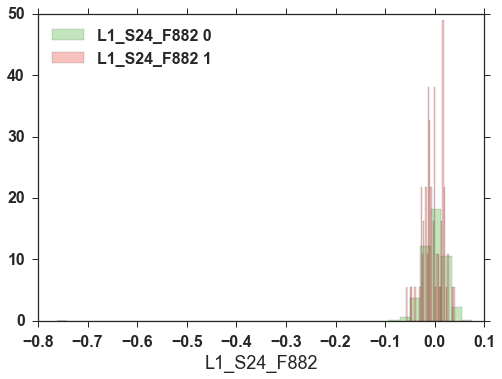

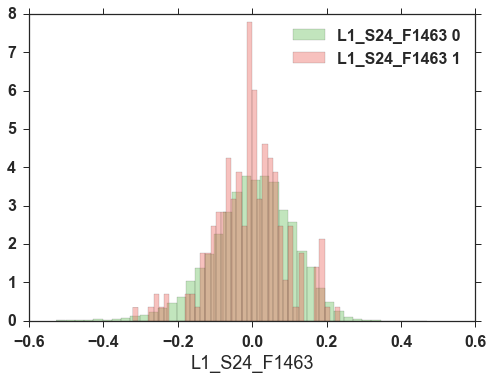

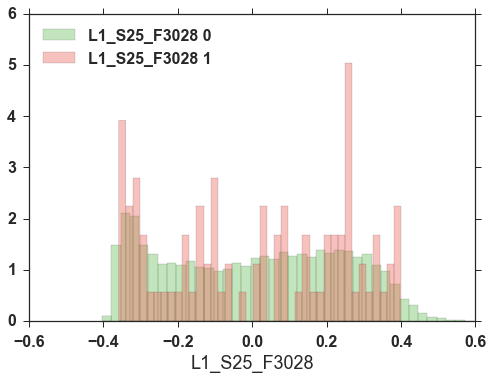

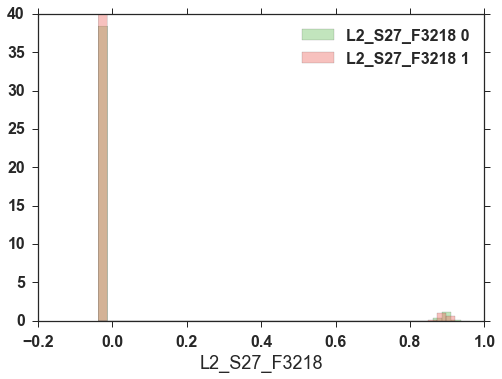

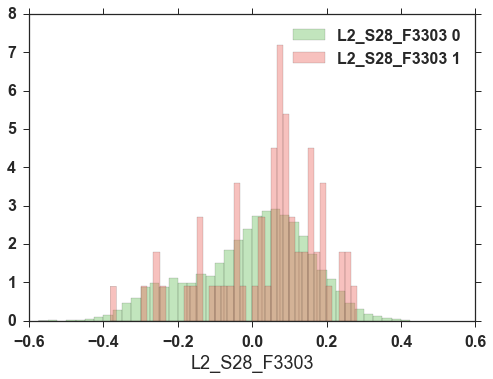

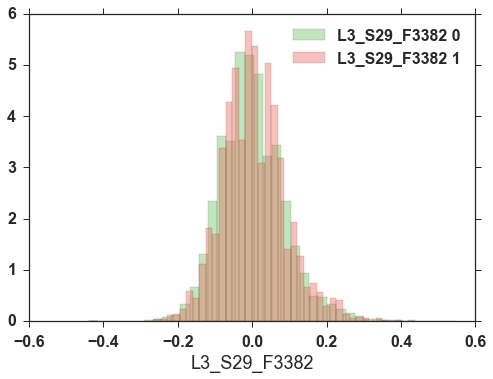

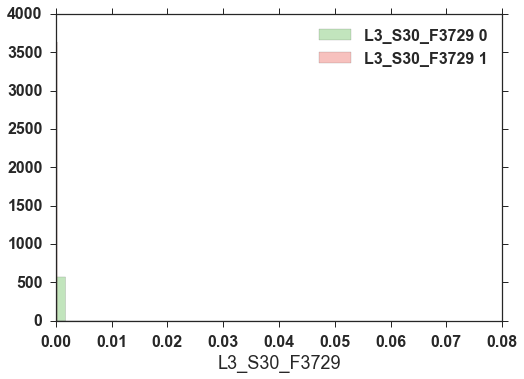

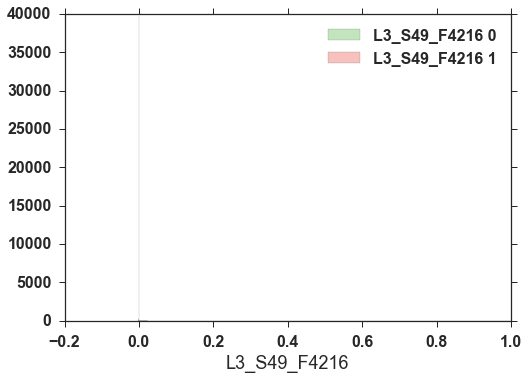

In [7]:
for f in cols[:-1]:
    for g in gb.groups:
        color = Tableau10_Medium['red'] if g>0 else Tableau10_Medium['green']
        a = sns.distplot(gb.get_group(g)[f].dropna()
                         , hist = True, kde=False
                         , label = "{:s} {}".format(f,g),
                        color=color, norm_hist=True, bins=40)
    a.legend(loc=0)
    plt.savefig("plots/{}.png".format(f))
    plt.show()
    plt.clf()

# Strategy:
* Build a multidimensional p-value from measurements and see how it is distributed (?)
* Find confidence interval, or cut on p-value that reduces dataset significantly (minimizing most important confusion matrix entry loss (fnr?))
* Predict remaining dataset with MVA classifier.

In [2]:
# first step is to get the mean and std values for each feature...
train_num = pd.read_csv("files/train_numeric.csv")

In [4]:
print(train_num.shape)
train_num.head(2)

(1183747, 970)


,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.03,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
train_num.Response.value_counts().apply(lambda x: 1e2*x/len(train_num))

0    99.418879
1     0.581121
Name: Response, dtype: float64

#### So there are only 0.58 % of pieces failing the quality control
Interestingly, when evaluating the perfect prediction on Kaggle, it is scored MCC=0.

In [3]:
def getMeanStd(data, cols=["mean","std"]):
    df = data[data.Response==0].drop(["Id","Response"],axis=1).describe()
    return df.drop(intersec(df.index.values,uninion(df.index.values,cols)),axis=0)    

In [1]:
def calcPVal(data, gaus_cols, droplist=["Id","Response"]):
    """
    Returns dataset where the entries are z scores. 
    Add chi2 column and dof column
    """
    import scipy.stats as st

    # calculate Z_i values 
    for col in data.drop(droplist,axis=1).columns.values:
        data.loc[:,col] = ((data.loc[:,col]-gaus_cols.loc["mean",col])\
                           /(gaus_cols.loc["std",col]))

    data["chi2"] = data.drop(droplist,axis=1).apply(lambda x: pow(x,2))\
                                             .sum(axis=1)
    data["dof"] = (~data.drop(droplist,axis=1).apply(np.isnan,axis=1))\
                                              .sum(axis=1)
    return data

In [7]:
gaus_pars.to_csv("files/lsf_mean_std.csv")

## Calculate multidimensional p value

In [1]:
import scipy.stats as st

Here we need to calculate the p value per row.

In [3]:
gaus_pars = pd.read_csv("files/lsf_mean_std.csv",index_col=0)

In [7]:
%time dd = calcPVal(train_num,gaus_cols=gaus_pars)

Wall time: 4min 47s


In [6]:
train_num.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [18]:
stats = dd.loc[:,["Id","Response","chi2","dof"]]

In [24]:
stats["pval"] = [st.distributions.chi2.sf(x,y) for x,y in zip(stats.chi2,stats.dof)]

## Prediction of failing chi2 calculation:
If chi2 cannot be calculated because all features are `NaN`.
* We clearly cannot decide based on numerical data.
* We need to consider this data in the next step.
* Lets keep the ids of these observations.
* We shouldn't just asign a prediction, as the rate of occurrence is about as high as the inital imbalance (2:580)

In [19]:
stats[stats.pval.isnull()][["Id","Response"]].to_csv("files/train_nan_pvals.csv")


In [27]:
stats = stats.dropna()

In [21]:
stats[stats.pval.isnull()]

,Id,Response,chi2,dof,pval


In [37]:
stats["chi2ndof"] = (stats.chi2)/(stats.dof)

In [91]:
stats.to_csv("files/train_statspvals.csv")
#stats = pd.read_csv("files/train_statspvals.csv", index_col=0)

In [38]:
gb=stats.groupby("Response", sort=False)

In [39]:
good = gb.get_group(0)
bad = gb.get_group(1)

In [47]:
good.describe()

,Id,Response,chi2,dof,pval,chi2ndof
count,1.176288e+06,1176288.0,1.176288e+06,1.176288e+06,1.176288e+06,1.176288e+06
mean,1.184120e+06,0.0,1.831933e+02,1.841941e+02,8.676170e-01,1.019625e+00
std,6.834593e+05,0.0,3.176978e+03,2.543519e+01,2.834668e-01,1.917094e+01
min,4.000000e+00,0.0,7.001532e-04,4.000000e+00,0.000000e+00,1.400306e-04
25%,5.921098e+05,0.0,1.082537e+02,1.620000e+02,9.444785e-01,5.802524e-01
50%,1.184874e+06,0.0,1.283464e+02,1.910000e+02,9.996214e-01,6.857622e-01
75%,1.775715e+06,0.0,1.537391e+02,2.050000e+02,9.999992e-01,8.367047e-01
max,2.367495e+06,0.0,1.144017e+06,3.280000e+02,1.000000e+00,7.195074e+03


In [46]:
bad.describe()

,Id,Response,chi2,dof,pval,chi2ndof
count,6.877000e+03,6877.0,6877.000000,6877.000000,6877.000000,6877.000000
mean,1.186589e+06,1.0,180.760439,183.182202,0.835268,1.008904
std,6.796249e+05,0.0,623.069099,26.021372,0.317051,4.558710
min,1.053000e+03,1.0,27.470685,47.000000,0.000000,0.259248
25%,6.083270e+05,1.0,109.669466,161.000000,0.889529,0.598982
50%,1.175134e+06,1.0,130.472352,191.000000,0.998909,0.709200
75%,1.775591e+06,1.0,158.324297,205.000000,0.999997,0.870219
max,2.366692e+06,1.0,36979.348151,275.000000,1.000000,318.787484


In [87]:
def condition(group):
    return ((group.chi2/group.dof)<10) & ((group.chi2/group.dof)<250)
   

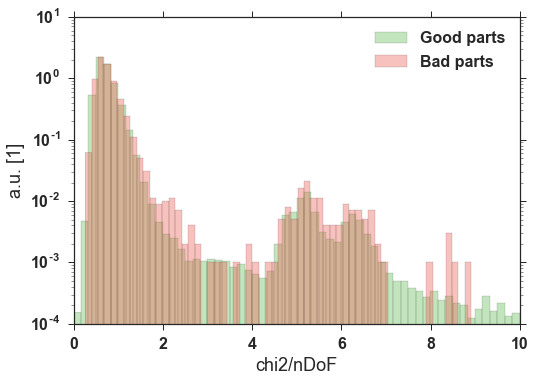

In [88]:
        
c = sns.distplot(good[condition(good)].chi2/good[condition(good)].dof,kde=None, bins=60, norm_hist=True,
                color=Tableau10_Medium['green'],hist_kws={"log":True},
                label="Good parts");
c = sns.distplot(bad[condition(bad)].chi2/bad[condition(bad)].dof,kde=None, bins=60, norm_hist=True,
                color=Tableau10_Medium['red'],hist_kws={"log":True},
                label="Bad parts");
c.legend();
c.set_xlabel("chi2/nDoF")
c.set_ylabel("a.u. [1]")

In [90]:
c.figure.savefig("chi2perdof.png")

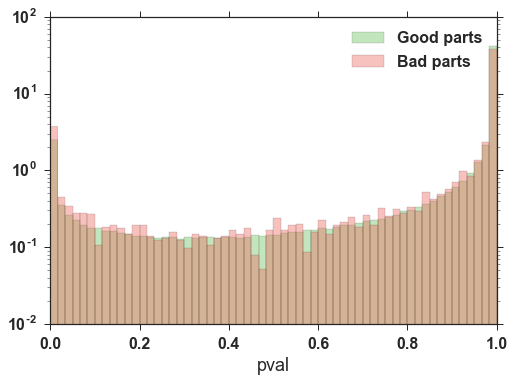

In [84]:
a = sns.distplot(good[condition(good)].pval,kde=None, bins=60, norm_hist=True,
                color=Tableau10_Medium['green'],hist_kws={"log":True},
                label="Good parts");
a = sns.distplot(bad[condition(bad)].pval,kde=None, bins=60, norm_hist=True,
                color=Tableau10_Medium['red'],hist_kws={"log":True},
                label="Bad parts");
a.legend();

In [89]:
a.figure.savefig("pVal_per_id.png")

This is a bit disappointing.

Let's try to look at pValues that are related to lines and stations. Therefore we need to group the columns.

In [4]:
def addLineStation(ds):
    l0=[]
    l1=[]
    l2=[]
    for c in ds:
        s = c.split(sep="_")
        l0.append(s[0])
        l1.append(s[0]+"_"+s[1])
        l2.append(c)
    return pd.MultiIndex.from_arrays([l0,l1,l2],names=["Line","Station","Feature"])

In [5]:
train_num = train_num.set_index(["Id","Response"])

In [6]:
mult_cols_index = addLineStation(train_num.columns.values)

In [7]:
train_num.columns = mult_cols_index

In [8]:
def sort_low_up(x):
    up = [5 if i>0 else i for i in x]
    low = [-5 if i<=0 else i for i in x]
    return up, low

In [9]:
def calcPVal_corr(series, means, cov):
    import scipy.stats as st
    # get integration boundaries
    up, low = sort_low_up(series)

    if np.isnan(np.sum(up)) or np.isnan(np.sum(low)):
        print("THIS SHOULD NO BE HAPPENING anymore!")
        return np.nan
    else:
        prob, _ = st.mvn.mvnun(low, up, means, cov, 5000)
        return prob

In [10]:
def getPVal_Station(grp, c, mstd):
    #df=data.T
    #gb = df.groupby(level=["Station"], sort=False, as_index=False)
    #df=df.T
    #for n,c in enumerate(gb.groups):
    g = grp.get_group(c)

    #if n>0 and n%5==0:
    #    print(n,"/",len(gb.groups)," groups processed...")
    #    print("current group: ", c)
    #    print(g.head())

    g = g.set_index(g.index.droplevel(["Line","Station"])).T
    features = g.columns.values
    cov = g.cov().values
    means = mstd[list(features)].loc["mean"]
    stds = mstd[list(features)].loc["std"]
    for i in range(len(features)):
        cov[i,i] = stds[i]**2 # correct estimation with
    col = ("pval_"+c,"pval_"+c,"pval_"+c)
    df[col] = np.NaN
    conditions=~g.isnull().apply(any,axis=1)
    df[col].loc[conditions] = g.loc[conditions].apply(lambda x: calcPVal_corr(x, means,cov),axis=1)
    return df

In [21]:
testset = train_num[(7000,):(100000,)]

### There are a lot of features that are not really gaussian.

First get rid of non gaussian features.

In [11]:
from scipy.stats.mstats import normaltest, zscore


In [12]:
from scipy.stats import normaltest as nt
from scipy.stats import shapiro, anderson

In [13]:
def normTest(group):
    t, p = shapiro(zscore(group.dropna()))
    return t

In [14]:
%time gaus = train_num.query("Response==0").groupby(level="Feature",axis=1)\
            .agg(normTest)

C:\Users\maxxo_000\Anaconda3\envs\jupnote\lib\site-packages\scipy\stats\morestats.py:1330: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Wall time: 2min 39s


In [16]:
# take best 350 features
gaus_features = (gaus.loc[(4,0)].sort_values(ascending=False)).head(350).index

In [20]:
cols = pd.DataFrame(columns=gaus_features.values)

In [22]:
cols.to_csv("files/most_gaussian_features.csv",index=False)